In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans

## LECTURA DE LOS DATOS

En primer lugar, se cargan los datos y se leen utilizando el método `.head()` sobre el objeto que contiene le data frame para mostrar las primeras filas y así hacernos una idea de los datos que contiene el archivo.

In [2]:
df = pd.read_csv('cancer_gene_expression_dataset_clean.csv') # leer dataset
df.head() # mostrar las primeras filas

,TP53,BRCA1,BRCA2,EGFR,KRAS,MYC,PTEN,RB1,APC,VHL,...,ATM,CHEK2,MLH1,MSH2,PALB2,RAD51,NF1,TSC1,TSC2,STK11
0,2.621229,2.294844,2.285151,3.162488,2.602772,2.000662,3.604151,3.030050,2.044993,2.728821,...,0.369233,0.085684,-0.057824,-0.150552,-0.739261,-0.359922,-0.230319,0.528561,0.171809,-0.881520
1,2.644670,2.086924,2.105762,2.326020,3.698626,2.595286,1.770801,2.213316,3.052054,2.992125,...,0.048539,0.484322,-0.351027,-0.163831,-0.196054,-0.731757,0.148060,0.130528,0.002557,-0.117294
2,1.942043,1.781996,2.277527,1.855014,2.667775,3.023350,2.820747,2.580678,2.965334,2.406773,...,0.113730,0.653571,-0.803742,0.092317,0.129941,0.390911,-0.618475,-0.660228,0.260971,0.148492
3,2.533690,2.987298,2.059414,2.213807,2.869632,2.081361,3.442306,3.219190,1.898180,2.915032,...,-0.223257,0.428199,0.107047,-0.622869,0.086590,0.192659,-0.441929,0.076863,0.029104,-0.571485
4,2.380817,2.821170,3.066866,2.706125,2.098054,2.728489,2.752416,2.908399,2.782879,4.212290,...,-0.396260,-0.057368,0.252494,0.432878,-0.600148,-0.167251,-0.237473,-0.326665,0.882727,0.202491


Antes de implementar ningún modelo, conviene escalar los datos. Hemos visto que todas las variables se sitúan en la misma escala, pero dado que hay presencia de outliers en algunos casos, conviene hacer un escalado de los datos. Además, como a continuación vamos a implementar un análisis de componentes principales (PCA), conviene aún más para centrar la media de los datos en 0 y que las variables que presentan valores anómalos no influyan excesivamente en la varianza.

In [3]:
X = df
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

# PCA

Antes de implementar un algoritmo de clustering para ver si los datos se agrupan siguiendo algún patrón, conviene realizar un análisis de componentes principales para hacer una comprobación visual. Como la dimensionalidad de los datos es considerablemente elevada, a partir del biplot obtenido en el PCA podremos apreciar si los datos se agrupan de forma intuitiva o no.

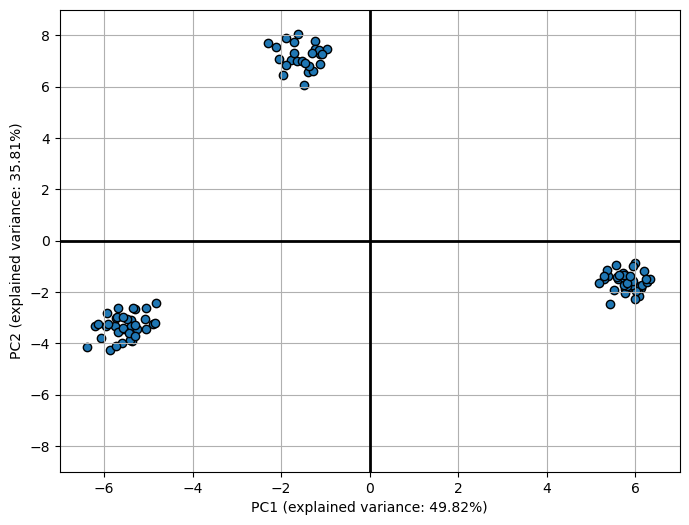

In [4]:
pca = PCA(n_components = 2) # inicializar PCA con dos componentes
pca_result = pca.fit_transform(X_scaled) # ajustar y transformar los datos escalados

# creamos un dataframe con las scores de cada componente principal 
df_pca = pd.DataFrame(data = pca_result, columns = ['PCA1', 'PCA2'])

# biplot
plt.figure(figsize=(8,6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], edgecolor = "black")
plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.ylim(-9, 9)
plt.xlim(-7, 7)
plt.hlines(y = 0, xmin = -10, xmax = 10, color = 'black', lw = 2)
plt.vlines(x = 0, ymin = -10, ymax = 10, color = 'black', lw = 2)
plt.grid()

Las dos primeras componentes explican más de un 80 % de la varianza, lo cual es satisfactorio. Además, se observa un agrupamiento muy bien definido de los datos en tres clusters distintos, muy homogéneos y muy diferentes entre sí. A continuación, vamos a comprobar si este agrupamiento también se da con la dimensionalidad original de los datos o resulta ser debido a la pérdida de información.

# CLUSTERING

Vamos a implementar el algoritmo de `K-means` para agrupar los datos en clusters. Para averiguar el número óptimo de clusters, vamos a iterar en un rango dado y comprobar cómo evoluciona la inercia en función del número de clusters. 

c:\Users\migog\miniconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\migog\miniconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\migog\miniconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\migog\miniconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is k

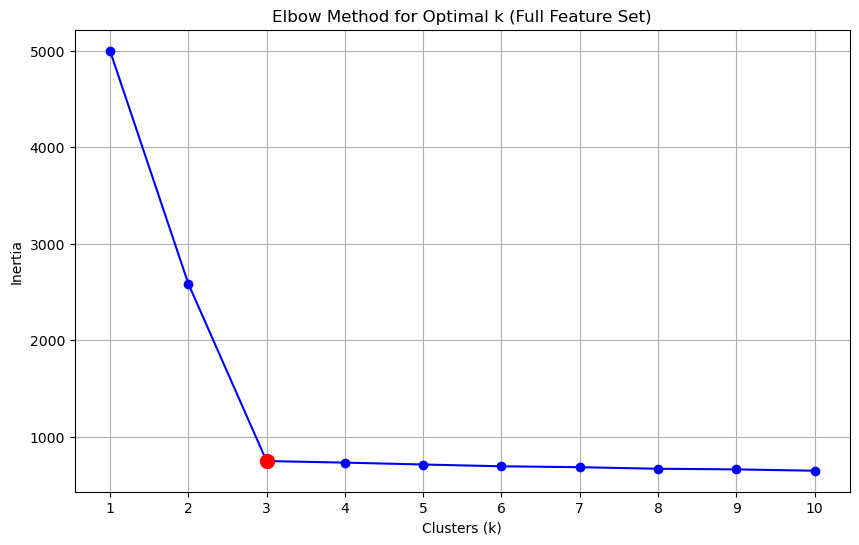

In [5]:
n_clusters_range = range(1, 11) # valores de k para evaluar
inertia_values = [] # inicailiza una lista para guardar los valores de inercia correspondientes a cada valor de k

for k in n_clusters_range:
    kmeans = KMeans(n_clusters = k, n_init = 10) # inicializa el algoritmo
    kmeans.fit(X_scaled) # ajusta los datos al modelo
    inertia_values.append(kmeans.inertia_) # guarda el valor de inercia obtenido para el valor de k actual en la lista

plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertia_values, marker = 'o', linestyle = '-', color = 'b')
plt.plot(3, inertia_values[2], marker = 'o', color = 'r', markersize = 10) # resalta el punto correspondiente a k = 3
plt.title('Elbow Method for Optimal k (Full Feature Set)')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()

Se observa cómo la inercia desciende abruptamente hasta $k = 3$. A partir de ahí, se estabiliza, por lo que ese es el número óptimo de clusters para este caso. Coincide perfectamente con el PCA realizado anteriormente, lo cuál es buena señal. Podemos extraer los datos de expresión génica para cada uno de los centroides:

In [6]:
kmeans = KMeans(n_clusters = 3, n_init = 10).fit(X_scaled) # ajustar el modelo para 3 clusters
centroids = kmeans.cluster_centers_ # niveles de expresión de los genes para los centroides de cada cluster

centroids_gene_expression = pd.DataFrame(centroids, columns = X.columns)
centroids_gene_expression.index.name = 'Cluster'
centroids_gene_expression.head()

c:\Users\migog\miniconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,TP53,BRCA1,BRCA2,EGFR,KRAS,MYC,PTEN,RB1,APC,VHL,...,ATM,CHEK2,MLH1,MSH2,PALB2,RAD51,NF1,TSC1,TSC2,STK11
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.317399,-0.314775,-0.385478,-0.356782,-0.452545,-0.337534,-0.373443,-0.388480,-0.317933,-0.386134,...,-0.451647,-0.571667,-0.453335,-0.558477,-0.491833,-0.469207,-0.473400,-0.567460,-0.569220,-0.538010
1,1.073657,1.066794,1.088351,1.097267,1.124609,1.063438,1.097977,1.094771,1.073186,1.104417,...,-0.564105,-0.451669,-0.553751,-0.453419,-0.508841,-0.508895,-0.536843,-0.450626,-0.443757,-0.508654
2,-1.273494,-1.266186,-1.201693,-1.256132,-1.165811,-1.228953,-1.233942,-1.207762,-1.271991,-1.226479,...,1.534874,1.523005,1.520671,1.507338,1.502713,1.471122,1.521709,1.515446,1.506920,1.567060


Dada la naturaleza de los datos, ¿cómo se interpretan los clusters? Corresponden a tres perfiles genéticos diferentes. Es decir, cada cluster agrupa a los pacientes que tienen un nivel de expresión similar para ciertos genes incluidos en el dataset. Esto puede visualizarse muy fácilmente con un mapa de calor que represente los datos extraídos de los centroides de cada cluster:

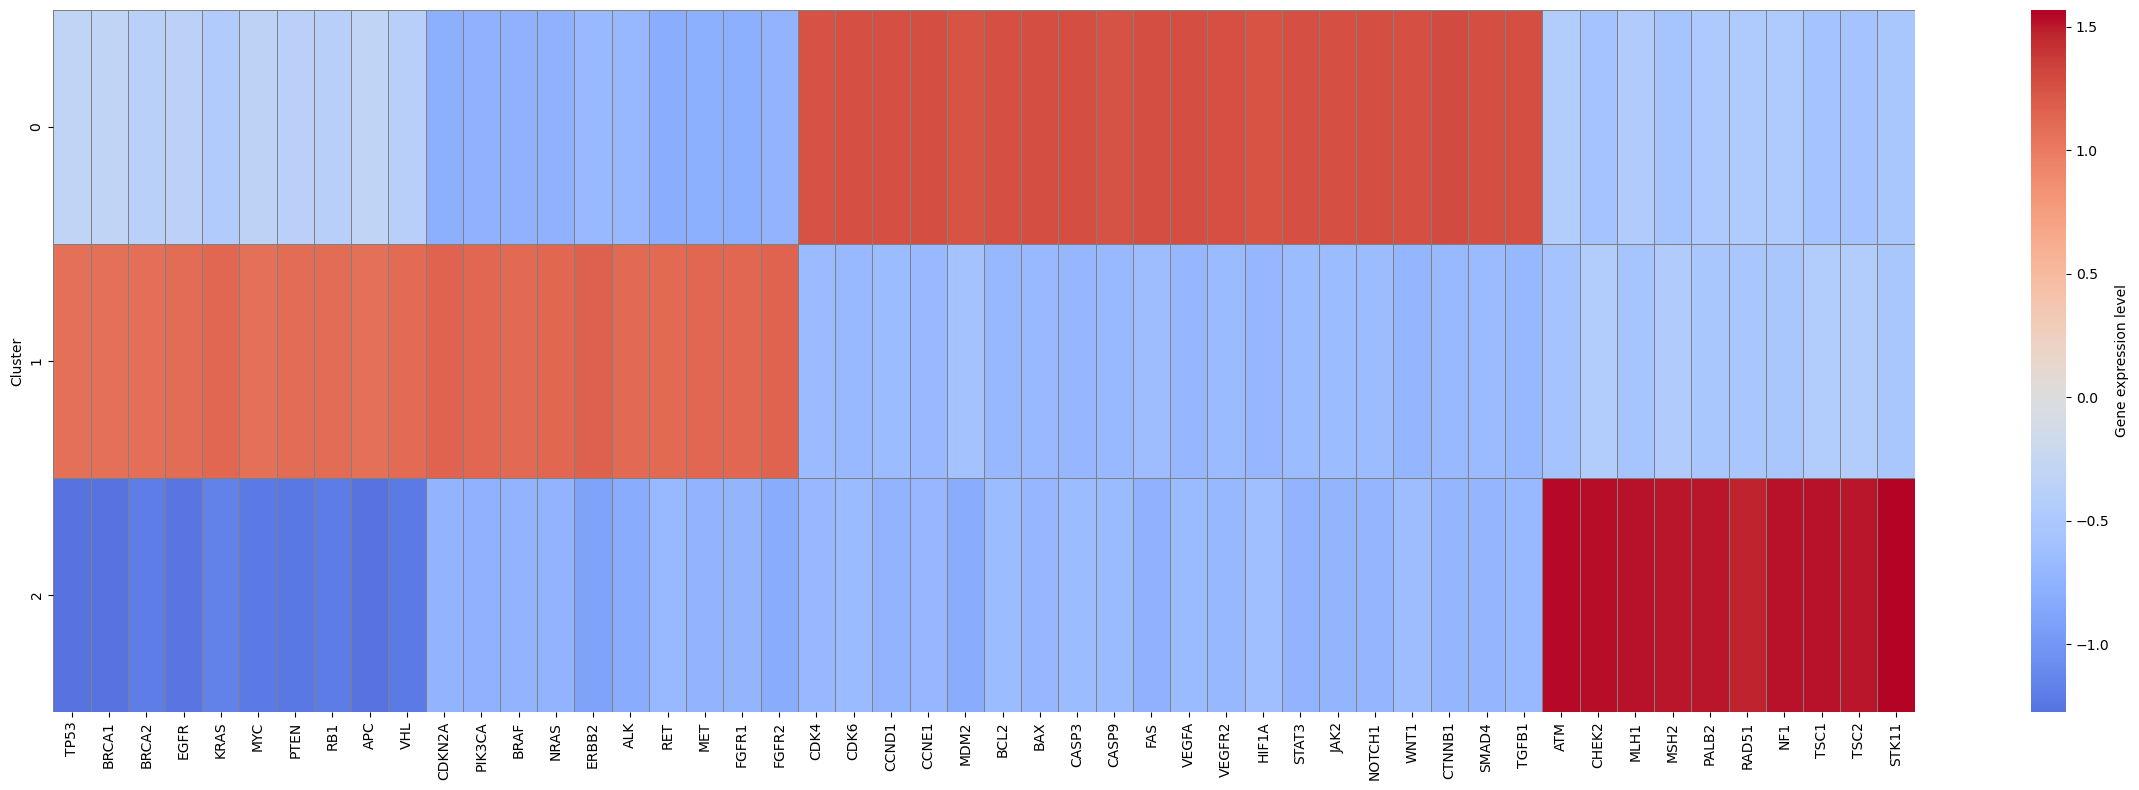

In [7]:
plt.figure(figsize = (24, 8))
sns.heatmap(centroids_gene_expression, 
            cmap = 'coolwarm',
            center = 0,
            vmin = centroids.min(),
            vmax = centroids.max(),
            linewidths = 0.5,
            linecolor = 'grey', 
            annot = False,
            xticklabels = True,
            cbar_kws={'label': 'Gene expression level'})
plt.tight_layout()
plt.show()

Las zonas rojas indican una mayor expresión de los genes representados. Como se puede observar, cada fila corresponde a un cluster, y cada cluster tiene unos genes cuyo nivel de expresión sobresale más que el resto.

Podemos "ampliar" la resolución haciendo el mapa de calor de cada uno de los registros:

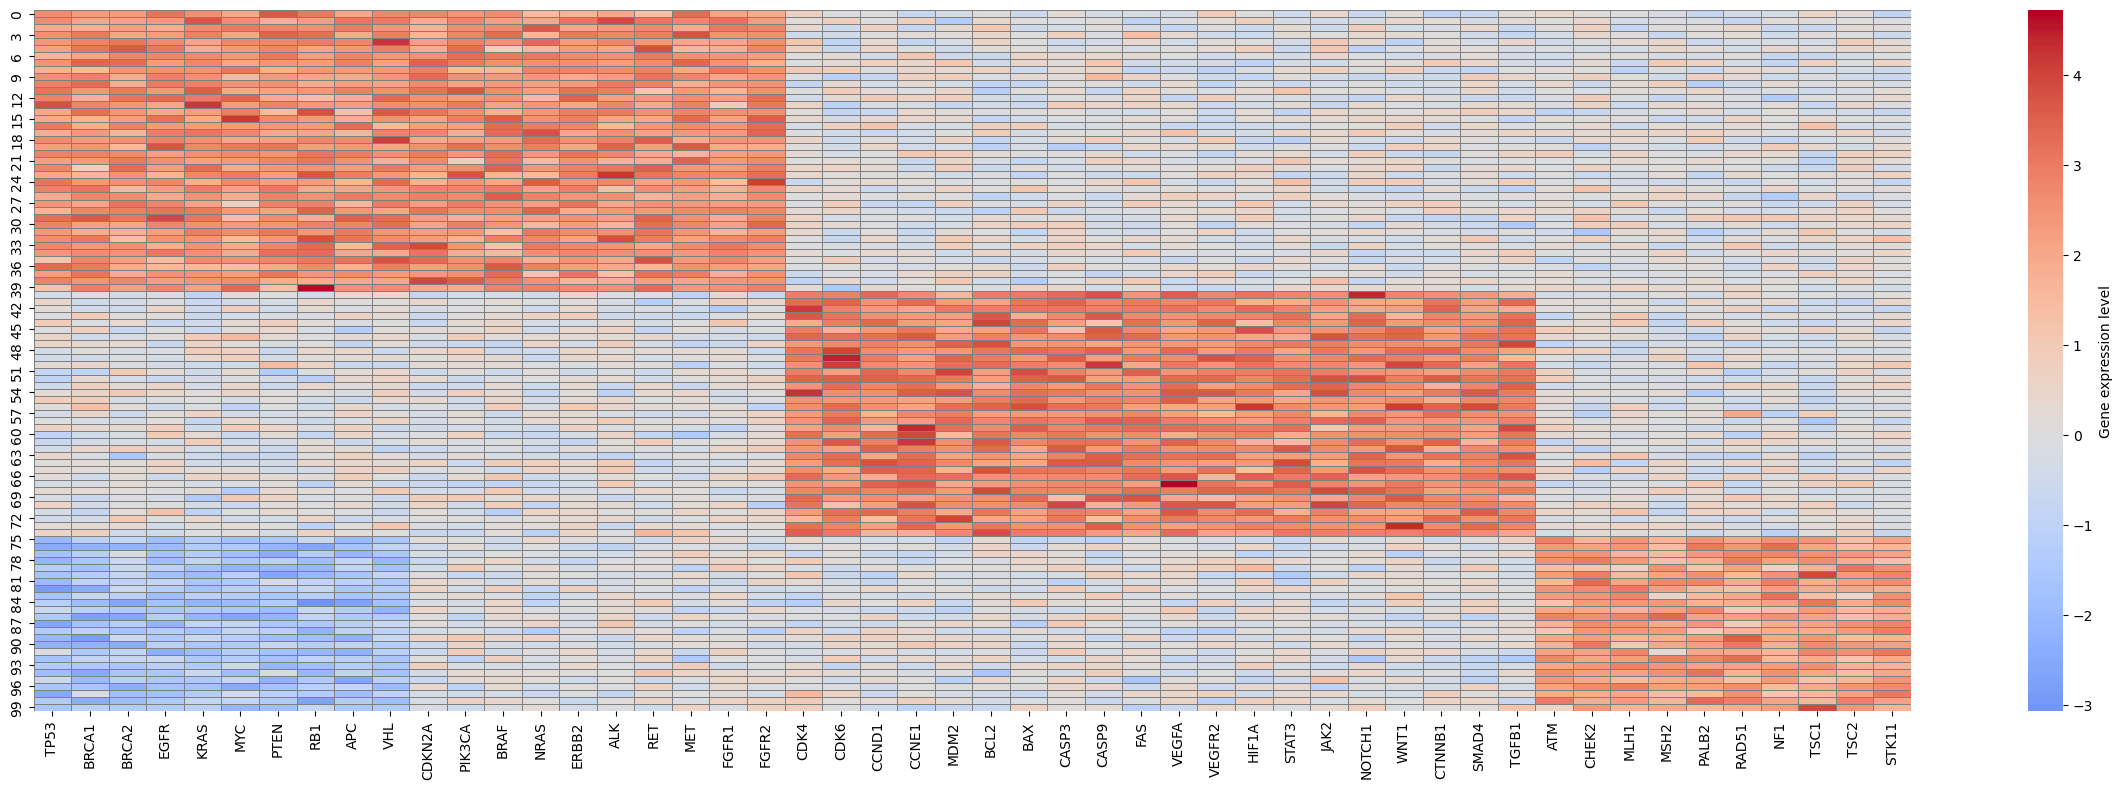

In [13]:
plt.figure(figsize = (24, 8))
sns.heatmap(df, 
            cmap = 'coolwarm',
            center = 0,
            vmin = df.values.min(),
            vmax = df.values.max(),
            linewidths = 0.5,
            linecolor = 'grey', 
            annot = False,
            xticklabels = True,
            cbar_kws={'label': 'Gene expression level'})
plt.tight_layout()
plt.show()

Efectivamente, podemos ver cómo los datos siguen el patrón definido por los centroides de forma bastante definida.

# CONCLUSIÓN

Hemos conseguido **agrupar a los pacientes** en tres clusters diferentes, definiendo así **tres perfiles genéticos distintos** atendiendo a la expresión de un conjunto particular de genes para cada uno de ellos. Este agrupamiento lo hemos implementado con el algoritmo `K-means` y hemos podido visualizarlo mediante un PCA y un mapa de calor que muestra los genes con mayor nivel de expresión en cada cluster.